In [2]:
import pandas as pd
import numpy as np
import os

import random
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
#from tensorflow.python.keras.preprocessing import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Creating Labels

In [3]:
directory = "/content/drive/MyDrive/data/pokemon_images/PokemonData"
labels = os.listdir(directory)
nb = len(labels)
print(labels)

['Arbok', 'Aerodactyl', 'Alolan Sandslash', 'Beedrill', 'Alakazam', 'Blastoise', 'Arcanine', 'Bellsprout', 'Abra', 'Articuno', 'Clefairy', 'Cloyster', 'Charizard', 'Butterfree', 'Charmeleon', 'Clefable', 'Bulbasaur', 'Charmander', 'Caterpie', 'Chansey', 'Doduo', 'Dragonair', 'Ditto', 'Dragonite', 'Dodrio', 'Dewgong', 'Dratini', 'Cubone', 'Diglett', 'Drowzee', 'Electrode', 'Electabuzz', 'Eevee', 'Exeggutor', 'Fearow', 'Ekans', 'Dugtrio', 'Farfetchd', 'Flareon', 'Exeggcute', 'Goldeen', 'Gastly', 'Graveler', 'Golem', 'Golbat', 'Geodude', 'Gloom', 'Gengar', 'Grimer', 'Golduck', 'Gyarados', 'Growlithe', 'Hitmonchan', 'Haunter', 'Horsea', 'Ivysaur', 'Hypno', 'Jolteon', 'Jigglypuff', 'Hitmonlee', 'Kangaskhan', 'Kabutops', 'Kabuto', 'Kadabra', 'Jynx', 'Kakuna', 'Koffing', 'Krabby', 'Kingler', 'Lapras', 'Magikarp', 'Magnemite', 'Machoke', 'Machop', 'Marowak', 'Lickitung', 'Mankey', 'Machamp', 'Magmar', 'Magneton', 'Moltres', 'Meowth', 'Metapod', 'Nidoqueen', 'Nidorina', 'Mewtwo', 'Muk', 'Mew', 

# Converting images to Numpy arrays
We will change the dimensions to 150 x 150 and normalize the pixel values.

In [33]:
stored = {}
def input_target_split(train_dir,labels):
    dataset = []
    count = 0
    for label in labels:
        folder = os.path.join(train_dir,label)
        for image in os.listdir(folder):
            
#             print(os.path.join(folder,image))
            try:
                img=load_img(os.path.join(folder,image), target_size=(150,150))
                img=img_to_array(img)
                img=img/255.0
                dataset.append((img,count))
            except:
                pass

        print(f'\rCompleted: {label}',end='')
        stored[label] = count
        count+=1
    random.shuffle(dataset)
    X, y = zip(*dataset)
    
    return np.array(X),np.array(y)

In [34]:
X, y = input_target_split(directory,labels)

Completed: Weedle

In [35]:
len(stored)

150

# Taking a look at the images and their labels

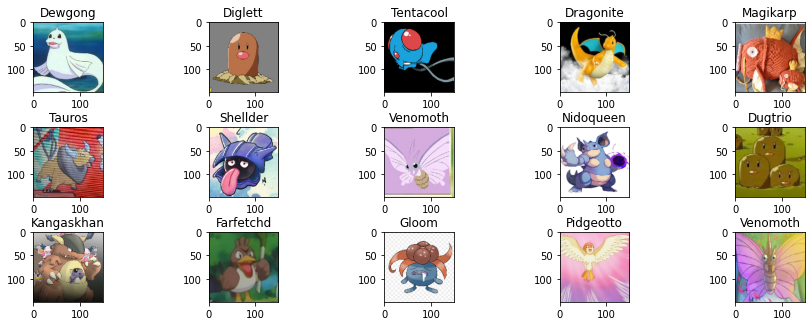

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(X[i])
    plt.title(labels[y[i]])

In [37]:
np.unique(y)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

# Train test split

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)

In [45]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             zoom_range=0.2,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range=0.1,
                             fill_mode="nearest")

testgen = ImageDataGenerator()

datagen.fit(X_train)
testgen.fit(X_test)

# Freezing the DenseNet201 model upto layer 675

In [46]:
y_train = np.eye(nb)[y_train]
y_test = np.eye(nb)[y_test]

In [47]:
from tensorflow.keras.applications import DenseNet201

img_size = 150
base_model = DenseNet201(include_top = False,
                         weights = 'imagenet',
                         input_shape = (img_size,img_size,3))

for layer in base_model.layers[:675]:
    layer.trainable = False

for layer in base_model.layers[675:]:
    layer.trainable = True

# Building the model

In [48]:
from keras import models,layers,Sequential, losses,metrics,optimizers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(nb, activation=tf.nn.softmax))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [49]:
filepath= "model_pokemon.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00001)

callbacks_list = [
        checkpoint,
        early_stopping,
        learning_rate_reduction
    ]

In [50]:
hist = model.fit(datagen.flow(X_train,y_train,batch_size=32),
                                        validation_data=testgen.flow(X_test,y_test,batch_size=32),
                                        epochs=50,
                                        callbacks=callbacks_list)

Epoch 1/50
167/167 [==============================] - ETA: 0s - loss: 3.1507 - accuracy: 0.3633
Epoch 1: val_accuracy improved from -inf to 0.68975, saving model to model_pokemon.h5
167/167 [==============================] - 39s 178ms/step - loss: 3.1507 - accuracy: 0.3633 - val_loss: 1.1568 - val_accuracy: 0.6897 - lr: 0.0010
Epoch 2/50
167/167 [==============================] - ETA: 0s - loss: 1.1227 - accuracy: 0.7560
Epoch 2: val_accuracy improved from 0.68975 to 0.82956, saving model to model_pokemon.h5
167/167 [==============================] - 27s 162ms/step - loss: 1.1227 - accuracy: 0.7560 - val_loss: 0.6785 - val_accuracy: 0.8296 - lr: 0.0010
Epoch 3/50
167/167 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.8514
Epoch 3: val_accuracy improved from 0.82956 to 0.84088, saving model to model_pokemon.h5
167/167 [==============================] - 27s 163ms/step - loss: 0.6578 - accuracy: 0.8514 - val_loss: 0.5920 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 4

# Classification Report

In [51]:
y_pred = model.predict(X_test)
pred = np.argmax(y_pred,axis=1)
print(pred)

[117  42 120 ... 120  24  75]


In [52]:
ground = np.argmax(y_test,axis=1)

In [53]:
from sklearn.metrics import classification_report

print(classification_report(ground,pred,target_names = labels))

                  precision    recall  f1-score   support

           Arbok       0.92      1.00      0.96        11
      Aerodactyl       0.89      0.67      0.76        12
Alolan Sandslash       0.90      1.00      0.95         9
        Beedrill       1.00      0.86      0.92         7
        Alakazam       0.67      0.86      0.75         7
       Blastoise       1.00      0.88      0.93         8
        Arcanine       1.00      0.82      0.90        11
      Bellsprout       1.00      1.00      1.00        11
            Abra       1.00      0.86      0.92         7
        Articuno       0.75      1.00      0.86         9
        Clefairy       1.00      1.00      1.00         9
        Cloyster       0.94      0.94      0.94        16
       Charizard       0.71      0.83      0.77         6
      Butterfree       1.00      0.75      0.86         4
      Charmeleon       1.00      1.00      1.00         5
        Clefable       1.00      0.92      0.96        12
       Bulbas

The model achieved an F1 score of 0.9.

In [54]:
y_pred = np.argmax(y_pred,axis=1)
y_pred

array([117,  42, 120, ..., 120,  24,  75])

In [55]:
y_true = np.argmax(y_test,axis=1)
y_true

array([141,  42, 120, ...,  97,  24,  75])

#Incorrectly classified images

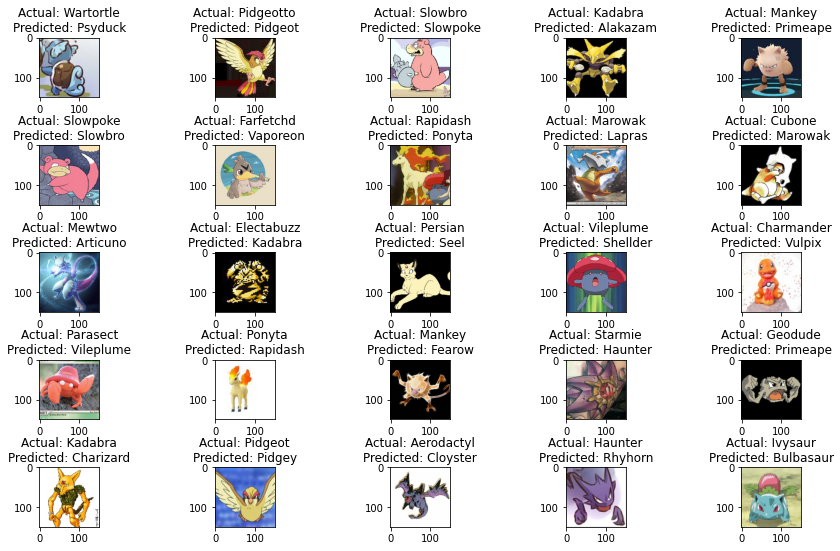

In [56]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(len(X_test)):
    if y_pred[i] != y_true[i]:
        n+=1
        if n <= 25:
            plt.subplot(5 , 5, n)
            plt.subplots_adjust(hspace = 0.8 , wspace = 0.3)
            plt.imshow(X_test[i])
            plt.title(f'Actual: {labels[y_true[i]]}\nPredicted: {labels[y_pred[i]]}')

The incorrectly classified Pokemon are actually very similar to the predicted ones. Humans could even mistake the two in some cases. 

Comparing some of these actuals with these with the following pokemon, we can see that they are in fact very similar in most cases, other than with Charizard and Kadabra.

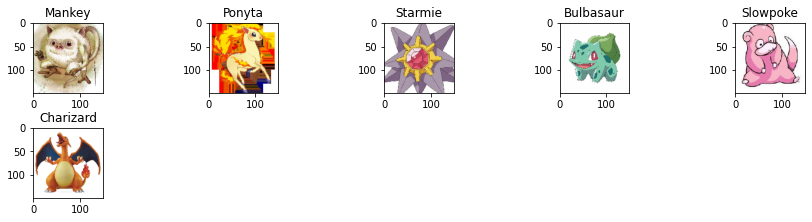

In [84]:
indexes = [28, 94, 124, 160, 154, 148]


plt.figure(figsize = (15 , 9))
n = 0
for i in indexes:
  n += 1
  plt.subplot(5 , 5, n)
  plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
  plt.imshow(X[i])
  plt.title(labels[y[i]])